## Docker specific configurations

Prepare python path

In [1]:
from sys import path
from pathlib import Path
path.append(str(Path("../../").resolve()))

## Prepare mesh

Generate mesh outside of the docker using the following commands:
```bash
gmsh metal.geo -2
../../tools/convert_msh.py metal.msh metal.xdmf
gmsh sibc.geo -2
../../tools/convert_msh.py sibc.msh sibc.xdmf
```

## Solution preparation

Import BeamImpedance2D module

In [2]:
import logging
import bi2d
from bi2d.materials import vacuum, beam
import numpy as np

Assign material indices. When setting index `-1` to SIBC material, boundary will be applied to all boundaries

In [3]:
beam.index = 1
vacuum.index = 2
metal = bi2d.Material(3, sigma=1/40e-9)
wall = metal.copy()
wall.index = -1

Setup mesh and materials

In [4]:
m_metal = bi2d.Mesh("metal.xdmf")
m_sibc = bi2d.Mesh("sibc.xdmf")
mc_metal = bi2d.MaterialMap(m_metal, [beam, vacuum, metal])
mc_sibc = bi2d.MaterialMap(m_sibc, [beam, vacuum])

Configure solution

In [5]:
solution_metal = bi2d.Solution(mc_metal, Hcurl_order=2, H1_order=2)
solution_sibc = bi2d.Solution(mc_sibc, Hcurl_order=2, H1_order=2)

In [7]:
def delta(f, sigma):
    return np.sqrt(2/(2*np.pi*f*sigma*4*np.pi*1e-7))

## Calculate impedance

Calculate impedance in frequency range and save the results

In [8]:
%%time

data_metal = solution_metal.get_z(np.logspace(1, 13, num=100), beta=0.99999, source_function=bi2d.SourceFunction.DIPOLE)

INFO:bi2d.solution:Solving for f=1.00e+01, β=1.00
INFO:bi2d.solution:Solving for f=1.32e+01, β=1.00
INFO:bi2d.solution:Solving for f=1.75e+01, β=1.00
INFO:bi2d.solution:Solving for f=2.31e+01, β=1.00
INFO:bi2d.solution:Solving for f=3.05e+01, β=1.00
INFO:bi2d.solution:Solving for f=4.04e+01, β=1.00
INFO:bi2d.solution:Solving for f=5.34e+01, β=1.00
INFO:bi2d.solution:Solving for f=7.05e+01, β=1.00
INFO:bi2d.solution:Solving for f=9.33e+01, β=1.00
INFO:bi2d.solution:Solving for f=1.23e+02, β=1.00
INFO:bi2d.solution:Solving for f=1.63e+02, β=1.00
INFO:bi2d.solution:Solving for f=2.15e+02, β=1.00
INFO:bi2d.solution:Solving for f=2.85e+02, β=1.00
INFO:bi2d.solution:Solving for f=3.76e+02, β=1.00
INFO:bi2d.solution:Solving for f=4.98e+02, β=1.00
INFO:bi2d.solution:Solving for f=6.58e+02, β=1.00
INFO:bi2d.solution:Solving for f=8.70e+02, β=1.00
INFO:bi2d.solution:Solving for f=1.15e+03, β=1.00
INFO:bi2d.solution:Solving for f=1.52e+03, β=1.00
INFO:bi2d.solution:Solving for f=2.01e+03, β=1.00


CPU times: user 1h 6min 13s, sys: 1min 56s, total: 1h 8min 10s
Wall time: 1h 8min 14s


In [9]:
%%time

data_sibc = solution_sibc.get_z(np.logspace(1, 13, num=100), beta=0.99999, source_function=bi2d.SourceFunction.DIPOLE, sibc=[wall])

INFO:bi2d.solution:Solving for f=1.00e+01, β=1.00
INFO:bi2d.solution:Solving for f=1.32e+01, β=1.00
INFO:bi2d.solution:Solving for f=1.75e+01, β=1.00
INFO:bi2d.solution:Solving for f=2.31e+01, β=1.00
INFO:bi2d.solution:Solving for f=3.05e+01, β=1.00
INFO:bi2d.solution:Solving for f=4.04e+01, β=1.00
INFO:bi2d.solution:Solving for f=5.34e+01, β=1.00
INFO:bi2d.solution:Solving for f=7.05e+01, β=1.00
INFO:bi2d.solution:Solving for f=9.33e+01, β=1.00
INFO:bi2d.solution:Solving for f=1.23e+02, β=1.00
INFO:bi2d.solution:Solving for f=1.63e+02, β=1.00
INFO:bi2d.solution:Solving for f=2.15e+02, β=1.00
INFO:bi2d.solution:Solving for f=2.85e+02, β=1.00
INFO:bi2d.solution:Solving for f=3.76e+02, β=1.00
INFO:bi2d.solution:Solving for f=4.98e+02, β=1.00
INFO:bi2d.solution:Solving for f=6.58e+02, β=1.00
INFO:bi2d.solution:Solving for f=8.70e+02, β=1.00
INFO:bi2d.solution:Solving for f=1.15e+03, β=1.00
INFO:bi2d.solution:Solving for f=1.52e+03, β=1.00
INFO:bi2d.solution:Solving for f=2.01e+03, β=1.00


CPU times: user 30min 26s, sys: 1min 1s, total: 31min 27s
Wall time: 31min 28s


## Plot impedances

In [10]:
import pylab
pylab.rcParams['figure.figsize'] = [12, 8]

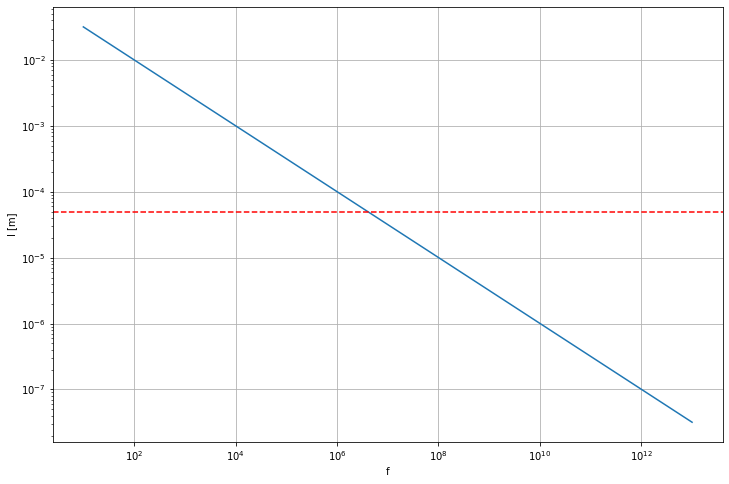

In [12]:
pylab.plot(data_metal[:,0], delta(data_metal[:,0]/1e3, metal.sigma))
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f, [Hz]")
pylab.ylabel(r"$\delta$, [mm]")
pylab.grid()
pylab.show()

Red line in the figure above is an element size near the metal-vacuum boundary

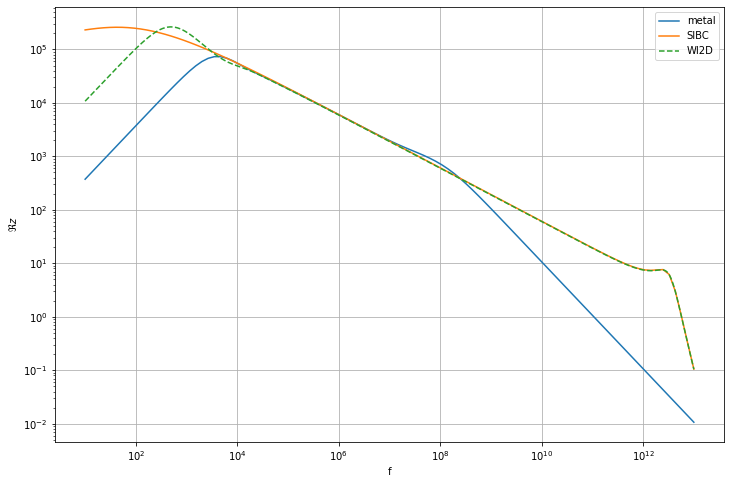

In [13]:
pylab.plot(data_metal[:,0], data_metal[:,1])
pylab.plot(data_sibc[:,0], data_sibc[:,1])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f")
pylab.ylabel(r"$\Re{z}, $")
pylab.grid()
pylab.legend([r"metal", "SIBC"])
pylab.show()

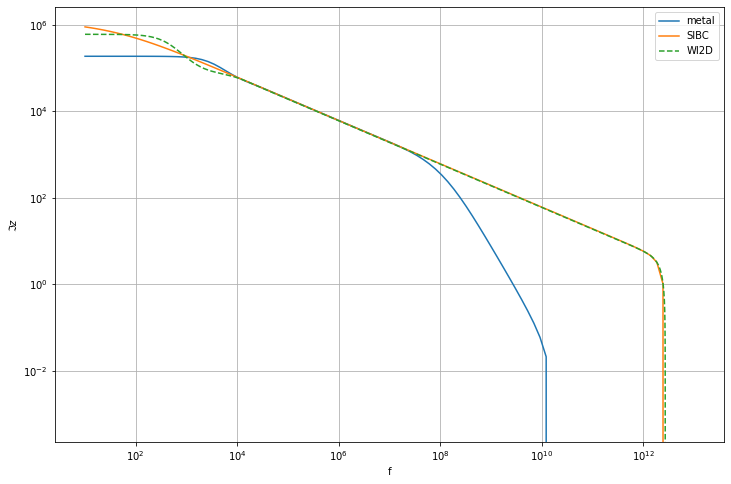

In [14]:
pylab.plot(data_metal[:,0], data_metal[:,2])
pylab.plot(data_sibc[:,0], data_sibc[:,2])
pylab.xscale("log")
pylab.yscale("log")
pylab.xlabel("f")
pylab.ylabel(r"$\Im{z}$")
pylab.grid()
pylab.legend([r"metal", r"SIBC", r"WI2D"])
pylab.show()